<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [61]:
# pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy      : 1.19.2
scipy      : 1.5.2
pandas     : 1.1.3
matplotlib : 3.3.2
statsmodels: 0.12.0
sklearn    : 0.23.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 



In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = "C:\\Users\\arxei\\Anaconda\\CourseraDeepLearning\\Course6\\UsersIdentification"

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [100]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [101]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [102]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [103]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(100, n_jobs=-1)
score = cross_val_score(knn, X_train.toarray(), y_train, cv=skf).mean()

In [12]:
knn2 = KNeighborsClassifier(100, n_jobs=-1).fit(X_train, y_train)
pred = knn2.predict(X_valid.toarray())

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [13]:
print(round(score,3), round(accuracy_score(y_valid, pred), 3))

0.563 0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
forest = RandomForestClassifier(100, oob_score=True, random_state=17, n_jobs=-1)
score = cross_val_score(forest, X_train, y_train, cv=skf).mean()

In [16]:
forest2 = RandomForestClassifier(100, oob_score=True, random_state=17, n_jobs=-1)
forest2.fit(X_train, y_train)
forest_pred = forest2.predict(X_valid)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [17]:
print(round(score, 3), round(accuracy_score(y_valid, forest_pred), 3))

0.716 0.735


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [104]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [19]:
logit = LogisticRegression(random_state=17)
score = cross_val_score(logit, X_train.toarray(), y_train, cv=skf).mean()

In [20]:
logit2 = LogisticRegression(random_state=17)
logit2.fit(X_train, y_train)
logit_pred = logit2.predict(X_valid)

In [21]:
print(round(score, 3), round(accuracy_score(y_valid, logit_pred), 3))

0.761 0.777


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [22]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, cv = skf, multi_class='multinomial', random_state=17, n_jobs = -1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 27.6 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

In [23]:
logit_grid_searcher1.score(X_valid, y_valid)

0.7755392273050485

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [24]:
logit_scores1 = []
score_max = -1

for _, row in logit_grid_searcher1.scores_.items():
    for elem in row:
        logit_scores1.append(elem)
        if score_max < np.max(elem):
            score_max = np.max(elem)
            c_max_index = np.argmax(elem)
logit_mean_cv_scores1 = []
for j in range (0, len(logit_c_values1)):
    logit_mean_cv_scores1.append(np.mean([logit_scores1[i][j] for i in range(0, len(logit_scores1))]))

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [25]:
print(score_max)
print(logit_c_values1[c_max_index])

0.7734756097560975
1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

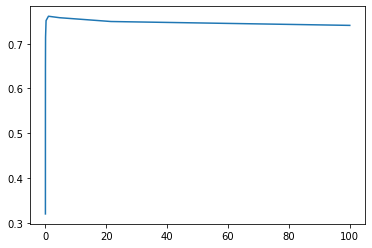

In [26]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [27]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, cv = skf, multi_class='multinomial', random_state=17, n_jobs = -1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 16s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

In [28]:
logit2_pred = logit_grid_searcher2.predict(X_valid)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [29]:
logit_scores2 = []
score_max = -1

for _, row in logit_grid_searcher2.scores_.items():
    for elem in row:
        logit_scores2.append(elem)
        if score_max < np.max(elem):
            score_max = np.max(elem)
            c_max_index = np.argmax(elem)
logit_mean_cv_scores2 = []
for j in range (0, len(logit_c_values2)):
    logit_mean_cv_scores2.append(np.mean([logit_scores2[i][j] for i in range(0, len(logit_scores2))]))

In [30]:
print(logit_grid_searcher2.score(X_valid, y_valid))

0.7795686181559611


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [31]:
print(score_max)
print(logit_c_values2[c_max_index])

0.7740853658536585
1.9157894736842107


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

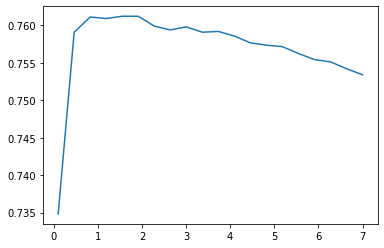

In [32]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [33]:
logit_cv_acc = accuracy_score(logit2_pred, y_valid)
print(logit_cv_acc)

0.7795686181559611


In [34]:
regr = LogisticRegression(random_state=17, n_jobs = -1, C=logit_c_values2[c_max_index])
score_regr = cross_val_score(regr, X_train.toarray(), y_train, cv=skf).mean()
print(score_regr)

0.7625494966089557


In [35]:
regr2 = LogisticRegression(random_state=17, n_jobs=-1, C=logit_c_values2[c_max_index])
regr2.fit(X_train, y_train)
regr2_pred = regr2.predict(X_valid)
print(regr2_pred)

[ 33 128  39 ... 207  39 237]


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [36]:
print(round(score_regr, 3), round(accuracy_score(y_valid, regr2_pred), 3))

0.763 0.782


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [37]:
from sklearn.svm import LinearSVC

In [38]:
svm = LinearSVC(C=1, random_state=17)
svm_score = cross_val_score(svm, X_train.toarray(), y_train, cv=skf).mean()

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [39]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm = LinearSVC(random_state=17)

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 3min 58s


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True)

In [40]:
print("Best score:", svm_grid_searcher1.best_score_)
C_best_svm = svm_grid_searcher1.best_params_['C']
print("Best C:", C_best_svm)

Best score: 0.6952843773612952
Best C: 4444.4445000000005


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

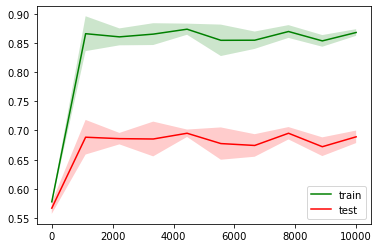

In [41]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [42]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 6min 18s


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [43]:
print("Best score:", svm_grid_searcher2.best_score_)
C_best_svm2 = svm_grid_searcher2.best_params_['C']
print("Best C:", C_best_svm2)

Best score: 0.7701686093803548
Best C: 0.10434482758620689


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

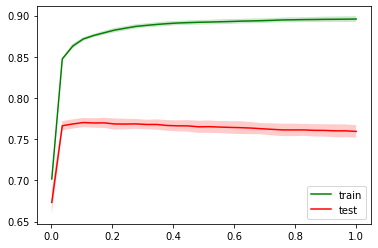

In [44]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [45]:
svm2_pred = svm_grid_searcher2.predict(X_valid)
svm_cv_acc = accuracy_score(svm2_pred, y_valid)

In [46]:
score_svm2 = svm_grid_searcher2.best_score_

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [50]:
print(score_svm2, svm_cv_acc)

0.7701686093803548 0.7807537331121118


In [47]:
print(round(score_svm2, 3), round(svm_cv_acc, 3))

0.77 0.781


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [204]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(os.path.join(PATH_TO_DATA, path_to_X_pickle), 'rb') as X_sparse_pkl:
        X = pickle.load(X_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, path_to_y_pickle), 'rb') as y_pkl:
        y = pickle.load(y_pkl)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    cv_score = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    #print("X.shape:", X_train.shape, X_test.shape, "Y.shape", y_train.shape, y_test.shape)

    y_pred = estimator.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)
    
    return cv_score, acc_score

**Убедитесь, что функция работает.**

In [205]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [202]:
# !cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/"window_data"/X_sparse_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/"window_data"/X_sparse_150users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/"window_data"/y_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/"window_data"/y_150users_s10_w10.pkl 

In [206]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, "window_data", f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, "window_data", f'y_10users_s{session_length}_w{window_size}.pkl')

        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

(0.8243252292702751, 0.828632377340602)
(0.7670206386611259, 0.7807537331121118)
(0.8495024256089474, 0.8583042973286876)
(0.7983645917156946, 0.8296001327360213)
(0.754765400423003, 0.7962502074000332)
(0.8670355547005402, 0.8658131816026553)
(0.8177520250854086, 0.8370080606922712)
(0.772939529035208, 0.80049786628734)
(0.7254849424351582, 0.7612612612612613)
Wall time: 14.2 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [72]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, "window_data", f'X_sparse_10users_s15_w5.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, "window_data", f'y_10users_s15_w5.pkl')

with open(os.path.join(PATH_TO_DATA, path_to_X_pkl), 'rb') as X_sparse_10users_s15_w5_pkl:
        X_sparse_10users_s15_w5 = pickle.load(X_sparse_10users_s15_w5_pkl)
with open(os.path.join(PATH_TO_DATA, path_to_y_pkl), 'rb') as y_10users_s15_w5_pkl:
        y_10users_s15_w5 = pickle.load(y_10users_s15_w5_pkl)
        
X_train, X_test, y_train, y_test = train_test_split(X_sparse_10users_s15_w5, y_10users_s15_w5, test_size=0.3, random_state=17, stratify=y_10users_s15_w5)        


In [78]:
svm_s15_w5 = LinearSVC(C=C_best_svm2, random_state=17)

cv_score = cross_val_score(svm_s15_w5, X_train.toarray(), y_train, cv=skf).mean()

svm_s15_w5.fit(X_train, y_train)
y_pred_s15_w5 = svm_s15_w5.predict(X_test)
acc_score = accuracy_score(y_pred_s15_w5, y_test)

In [81]:
print(round(cv_score, 3), round(acc_score, 3))

0.867 0.875


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [91]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, "window_data", f'X_sparse_150users_s10_w10.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, "window_data", f'y_150users_s10_w10.pkl')

with open(os.path.join(PATH_TO_DATA, path_to_X_pkl), 'rb') as X_sparse_150users_s10_w10_pkl:
        X_sparse_150users_s10_w10 = pickle.load(X_sparse_150users_s10_w10_pkl)
with open(os.path.join(PATH_TO_DATA, path_to_y_pkl), 'rb') as y_150users_s10_w10_pkl:
        y_150users_s10_w10 = pickle.load(y_150users_s10_w10_pkl)
        
X_train, X_test, y_train, y_test = train_test_split(X_sparse_150users_s10_w10, y_150users_s10_w10, test_size=0.3, random_state=17, stratify=y_150users_s10_w10)        


In [95]:
%%time

svm_150users = LinearSVC(C=C_best_svm2, random_state=17)

cv_score = cross_val_score(svm_150users, X_train, y_train, cv=skf).mean()

svm_150users.fit(X_train, y_train)
y_pred_150users = svm_150users.predict(X_test)
acc_score = accuracy_score(y_pred_150users, y_test)

Wall time: 4min 21s


In [96]:
print(round(cv_score, 3), round(acc_score, 3))

0.463 0.484


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.**

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

*Поиск лучшего C для 10 юзеров (повторно)*

In [105]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [106]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

In [107]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, cv = skf, multi_class='multinomial', random_state=17, n_jobs = -1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 50.3 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

In [111]:
best_C = logit_grid_searcher2.C_[0]

In [112]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [113]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [159]:
%%time
# logit_cv_150users = LogisticRegressionCV(Cs = [best_C], multi_class='ovr', cv=skf, n_jobs=-1, random_state=17)
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], random_state=17, n_jobs=-1, multi_class='ovr', cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 9min 19s


LogisticRegressionCV(Cs=[3.7315789473684213],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [160]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    mean_score_user = np.mean(logit_cv_150users.scores_[user_id])
    cv_scores_by_user[user_id] = mean_score_user
    print('User {id}, CV score: {score}'.format(id=user_id, score=mean_score_user))

User 6, CV score: 0.9961110589805345
User 13, CV score: 0.9963612857485429
User 15, CV score: 0.9952769697538395
User 16, CV score: 0.9917946472323876
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9941718015284685
User 33, CV score: 0.9937234785691199
User 39, CV score: 0.9858309092615182
User 46, CV score: 0.9979669075099308
User 49, CV score: 0.9953082480998404
User 50, CV score: 0.994286488797139
User 53, CV score: 0.993587939069782
User 65, CV score: 0.9968825915152273
User 66, CV score: 0.9947869423331562
User 82, CV score: 0.9963195812872083
User 85, CV score: 0.9963821379792104
User 89, CV score: 0.9907103312376843
User 92, CV score: 0.9944011760658097
User 100, CV score: 0.9944428805271444
User 102, CV score: 0.9912003586583675
User 103, CV score: 0.9806491299406753
User 105, CV score: 0.9969451482072295
User 106, CV score: 0.9948390729098245
User 118, CV score: 0.9910022624670275
User 119, CV score: 0.9965802341705503
User 120, CV score: 0.9943177671431401
User 12

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [170]:
class_distr = np.bincount(y_train_150.astype('int'))
dif_scores_by_user = {}

for user_id in np.unique(y_train_150):
    print("CV_SCORES_BY_USER:0", cv_scores_by_user[user_id])
    print("RATIO:", class_distr[user_id] / (np.sum(class_distr) - class_distr[user_id]))
    dif = cv_scores_by_user[user_id] - (1 - class_distr[user_id] / (np.sum(class_distr) - class_distr[user_id]))
    dif_scores_by_user[user_id] = dif

CV_SCORES_BY_USER:0 0.9961110589805345
RATIO: 0.015844604255589565
CV_SCORES_BY_USER:0 0.9963612857485429
RATIO: 0.004314090951927205
CV_SCORES_BY_USER:0 0.9952769697538395
RATIO: 0.0056303472571716156
CV_SCORES_BY_USER:0 0.9917946472323876
RATIO: 0.015521932935932322
CV_SCORES_BY_USER:0 0.9903558433163387
RATIO: 0.012199626412824382
CV_SCORES_BY_USER:0 0.9941718015284685
RATIO: 0.005577630765037062
CV_SCORES_BY_USER:0 0.9937234785691199
RATIO: 0.007510661988697241
CV_SCORES_BY_USER:0 0.9858309092615182
RATIO: 0.016350535127688883
CV_SCORES_BY_USER:0 0.9979669075099308
RATIO: 0.00288591235609649
CV_SCORES_BY_USER:0 0.9953082480998404
RATIO: 0.006210593678203124
CV_SCORES_BY_USER:0 0.994286488797139
RATIO: 0.005883463377800151
CV_SCORES_BY_USER:0 0.993587939069782
RATIO: 0.008018917498686285
CV_SCORES_BY_USER:0 0.9968825915152273
RATIO: 0.0030851931644669413
CV_SCORES_BY_USER:0 0.9947869423331562
RATIO: 0.005166631733389227
CV_SCORES_BY_USER:0 0.9963195812872083
RATIO: 0.003662505362954

In [171]:
num_better_than_default = (np.array(list(dif_scores_by_user.values())) > 0).sum()
print(num_better_than_default)

123


**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [176]:
print(round(num_better_than_default/len(np.unique(y_train_150)), 3))

0.82


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [183]:
print(y_150users)

[   6    6    6 ... 2902 2902 2902]


In [184]:
y_binary_128 = [1 if user_id == 128 else 0 for user_id in y_150users]

In [185]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [188]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train, y_train, train_sizes=train_sizes, random_state=17, cv=skf)

Wall time: 21.5 s


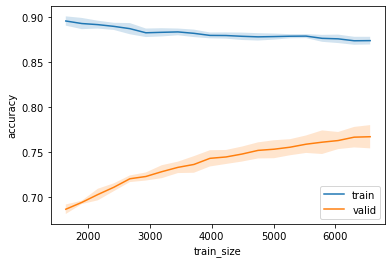

In [189]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.